In [70]:
import numpy as np
from matplotlib import pyplot as plt
import copy
from scipy.sparse.linalg import eigs, eigsh
from scipy.sparse import eye, spdiags, dia_matrix
import warnings
from IPython.display import clear_output
from scipy import signal
from scipy.optimize import root_scalar

In [2]:
warnings.filterwarnings(action="error", category=np.ComplexWarning)

In [3]:
def V(Nx, V0):
    v = np.zeros(Nx)
    for i in range(int(Nx/3), int(2*Nx/3)):
        v[i] = V0
    v = spdiags(v, 0, Nx, Nx)
    return v

def getEigs(N, delta, Nn, V0):
    lap = dia_matrix((N, N), dtype=np.complex128)
    lap += -2.5*eye(N) + 4/3*eye(N, k = -1) + 4/3*eye(N, k = 1) - 1/12*eye(N, k = -2) - 1/12*eye(N, k = 2)
    v = V(N, -V0*delta**2)
    lap += v
    values, modes = eigs(lap, k = Nn, which = "SM")
    values *= -1/delta**2
    functions = np.zeros([Nn, N+2], dtype = np.complex64)
    functions.T[1:-1] = modes
    functions *= 1/np.sqrt(delta)
    #functions *= 1/np.sqrt(delta*np.sum(functions.T[0]**2))
    return values, functions

def errorOfX(n):
    n = int(n)
    N = np.linspace(100, 100 + 50*(n-1), n, dtype = int)
    Errors = np.zeros(n)
    P = 0
    for i in range(n):
        vals, modes = getEigs(N[i], 1/(N[i]-1), 1)
        x = np.linspace(0, 1, N[i]+2)
        deltaE = np.absolute(np.sqrt(2)*np.sin((P+1)*np.pi*x[1:-1])) - np.absolute(modes[P][1:-1])
        relE = np.absolute(deltaE)/np.absolute(np.sqrt(2)*np.sin((P+1)*np.pi*x[1:-1]))
        Errors[i] = np.mean(relE)
    return N, Errors


def innerprod(psi1, psi2, delta):
    return delta*np.sum(np.conj(psi1)*psi2)

def psi_0(x):
    return np.sqrt(2)*np.sin(np.pi*x)

# def psi_0(x):
#     delta = x[1]-x[0]
#     ind = np.where(x == 0.5)
#     psi0 = np.zeros(len(x))
#     psi0[ind] = 1/delta
#     return psi0

def degenerate(lambdas, psis):
    NewLambdas, NewPsis = np.array([], dtype = np.complex), np.empty(shape=[0, len(psis[0])], dtype = np.complex)
    NewLambdas =  np.append(NewLambdas, lambdas[0])
    NewPsis = np.append(NewPsis, np.array([psis[0]]), axis = 0)
    for i in range(1, len(lambdas)):
        #lam = np.round(np.real(lambdas[i]), -2)
        #if lam !=  np.round(np.real(lambdas[i+1]), -2):
        if lambdas[i-1] < lambdas[i]*0.95:
            NewLambdas = np.append(NewLambdas, lambdas[i])
            NewPsis = np.append(NewPsis, np.array([psis[i]]), axis = 0)
    return NewLambdas, NewPsis

In [50]:
def main1(Nx, x0, x1, Nn, t, V0):
    x = np.linspace(x0,x1,Nx)
    deltax = x[1] - x[0]
    psi0 = psi_0(x)
    lambdas, psis = getEigs(Nx-2, deltax, Nn, V0)
    #plt.figure()
    #plt.plot(x, np.absolute(psis[0]))
    #n = np.linspace(1, Nn, Nn)
    #plt.plot(n, (np.pi*n)**2)
    #plt.plot(n, np.absolute(lambdas))
    #plt.show()
    alpha = np.array([innerprod(psis[i],psi0, deltax) for i in range(Nn)])
    PSI = np.zeros(Nx, dtype = np.complex)
    for i in range(Nn):
        PSI += alpha[i]*np.exp(-1j*lambdas[i]*t)*psis[i]
    return x, PSI

def main2(Nx, x0, x1, Nn, V0):
    x = np.linspace(x0,x1,Nx)
    deltax = x[1] - x[0]
    lambdas, psis = getEigs(Nx-2, deltax, Nn, V0)
    lambdas, psis = degenerate(lambdas, psis)
    p1, p2 = np.argmax(np.absolute(psis[0])), np.argmax(np.absolute(psis[1]))
#     while np.abs(p1-p2) > 0.25*Nx:
#         lambdas, psis = getEigs(Nx-2, deltax, Nn, V0)
#         lambdas, psis = degenerate(lambdas, psis)
#         p1, p2 = np.argmax(np.absolute(psis[0])), np.argmax(np.absolute(psis[1]))
    print(p1, p2)
    Nn = len(lambdas)
    psi0 = 1/np.sqrt(2)*(psis[0]+psis[1])
    Nj = 100
    T = np.pi/(lambdas[1]-lambdas[0])/Nj
    #print(t)
    #print(np.pi/(lambdas[1]-lambdas[0]))
    #plt.figure()
    #plt.plot(x, np.real(psis[0]))
    #plt.plot(x, np.real(psis[1]))
    #plt.plot(x, np.real(psis[1]))
    #plt.plot(x, np.real(psi0))
    #plt.plot(x, np.real(psis[0]+psis[1]))
    #n = np.linspace(1, Nn, Nn)
    #plt.plot(n, (np.pi*n)**2)
    #plt.plot(n, np.absolute(lambdas))
    #plt.show()
    #return 0,0
    alpha = np.array([innerprod(psis[i], psi0, deltax) for i in range(Nn)])
    for j in range(Nj+1):
        PSI = np.zeros(Nx, dtype = np.complex)
        t = j*T
        for i in range(Nn):
            PSI += alpha[i]*np.exp(-1j*lambdas[i]*t)*psis[i]
        plt.plot(x, np.absolute(PSI)**2)
        plt.plot(x, 5*np.heaviside(x-0.33, 1)-5*np.heaviside(x-0.67,1))
        plt.title(f"t = {j}")
        plt.show()
        clear_output(wait=True)
    return x, PSI, psi0, T, alpha

In [62]:
def f(lamda, v0):
    k = np.sqrt(lamda)
    kappa = np.sqrt(v0-lamda)
    return np.exp(kappa/3)*(kappa*np.sin(k/3)+np.cos(k/3))**2-np.exp(-kappa/3)*(kappa*np.sin(k/3)-k*np.cos(k/3))**2

In [83]:
# lamda = np.linspace(0, 1000, 10000)
# FF = f(lamda, 1000)
# plt.plot(lamda, FF)

print(root_scalar(f, args=(1000), bracket=[0, 1000], method='brentq'))

      converged: True
           flag: 'converged'
 function_calls: 13
     iterations: 12
           root: 986.4236892063556


In [271]:
np.round(73.47, -2)


100.0

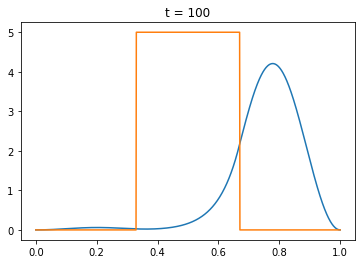

In [85]:

x, PSI, PSI0, T, alpha = main2(1000, 0, 1, 3, 100)

Text(0.5, 0, 'x')

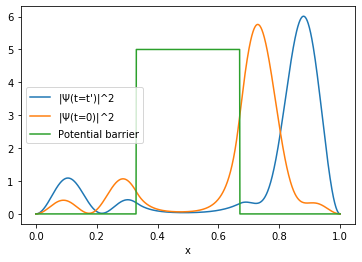

In [60]:
plt.plot(x, np.absolute(PSI)**2, label = r"|$\Psi$(t=t')|^2")
plt.plot(x, np.absolute(PSI0)**2, label = r"|$\Psi$(t=0)|^2")
plt.plot(x, 5*np.heaviside(x-0.33, 1)-5*np.heaviside(x-0.67,1), label = "Potential barrier")
plt.legend()
plt.xlabel("x")

In [33]:
print(len(alpha))

3


(0.0001577450968522817+2.1028168469395683e-17j)
0.050030060983445666
0.0482797303355677


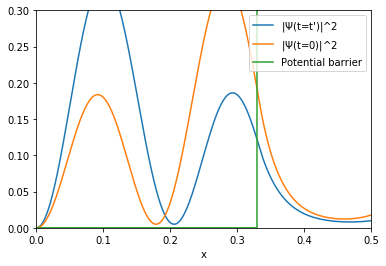

In [47]:
plt.plot(x, np.absolute(PSI)**2, label = r"|$\Psi$(t=t')|^2")
plt.plot(x, np.absolute(PSI0)**2, label = r"|$\Psi$(t=0)|^2")
plt.plot(x, 5*np.heaviside(x-0.33, 1)-5*np.heaviside(x-0.67,1), label = "Potential barrier")
plt.legend()
plt.xlabel("x")
print(T)
plt.xlim(0, 0.5)
plt.ylim(0, 0.3)
print(np.sum(np.absolute(PSI[:333])**2)*(x[1]-x[0]))
print(np.sum(np.absolute(PSI0[:333])**2)*(x[1]-x[0]))

(0.00014263888757057677+2.4899901284514576e-17j)


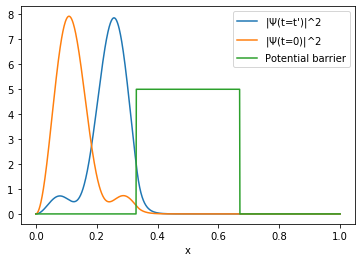

In [25]:
plt.plot(x, np.absolute(PSI)**2, label = r"|$\Psi$(t=t')|^2")
plt.plot(x, np.absolute(PSI0)**2, label = r"|$\Psi$(t=0)|^2")
plt.plot(x, 5*np.heaviside(x-0.33, 1)-5*np.heaviside(x-0.67,1), label = "Potential barrier")
plt.legend()
plt.xlabel("x")
print(T)
# plt.xlim(0, 0.5)
# plt.ylim(0, 0.1)
# print(np.sum(np.absolute(PSI[:333])**2)*(x[1]-x[0]))
# print(np.sum(np.absolute(PSI0[:333])**2)*(x[1]-x[0]))

In [13]:
%matplotlib notebook
x, PSI = main1(101, 0, 1, 19, 0.5, 1000)

[  73.47429228-0.j   73.47216322-0.j  291.71417542-0.j  291.73988109-0.j
  644.6550405 -0.j  645.15405311-0.j 1033.63668117-0.j 1084.79740248-0.j
 1178.88531061-0.j 1380.38947961-0.j 1614.25208944-0.j 1797.07273805-0.j
 2013.28457473-0.j 2316.77812273-0.j 2595.3755892 -0.j 2864.20940651-0.j
 3212.85223616-0.j 3567.50197763-0.j 3898.70050192-0.j]


In [11]:
T = 0.01421870084463251/100
for i in range(10):
    x, PSI = main2(51, 0, 1, 10, 1000, T*i)
#plt.plot(x, np.real(PSI), label = "Real part")
#plt.plot(x, np.imag(PSI), label = "Imaginary part")
    plt.plot(x, np.absolute(PSI))
    plt.title(f"t = {i*T}")
    #plt.legend()
    plt.show()
    clear_output(wait=True)

9 45


KeyboardInterrupt: 

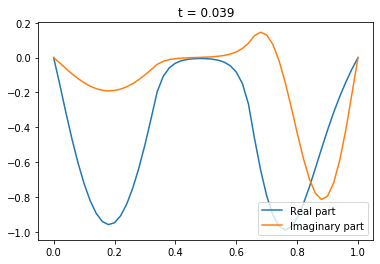

In [6]:
%matplotlib inline
for i in range(40):
    x, PSI = main1(51, 0, 1, 3, 0.001*i, 1000)
    plt.plot(x, np.real(PSI), label = "Real part")
    plt.plot(x, np.imag(PSI), label = "Imaginary part")
    plt.title(f"t = {i*0.001}")
    plt.legend(loc = 4)
    plt.show()
    clear_output(wait=True)

0.9997735659961695


<IPython.core.display.Javascript object>


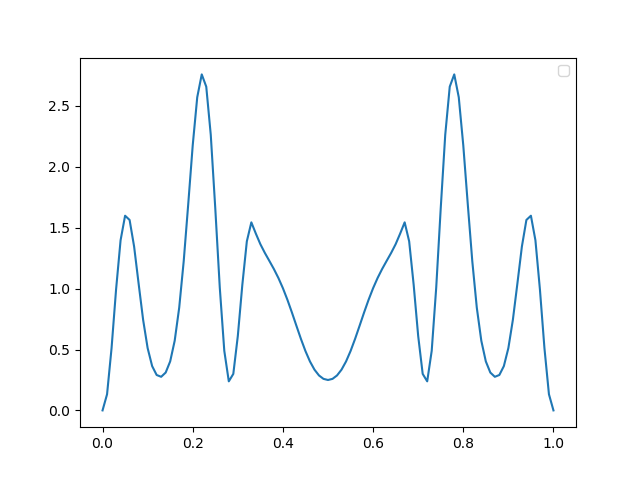

No handles with labels found to put in legend.


In [15]:
delta = 1/100
print(np.sum(np.absolute(PSI**2))*delta)

#plt.plot(x, np.imag(PSI), label = "Imag")
#plt.plot(x, np.real(PSI), label = "Real")
plt.plot(x, np.absolute(PSI)**2)
plt.legend()

In [470]:
%matplotlib notebook
vals, modes = getEigs(100, 0, 1, 5)
N, E = errorOfX(1)
print(N)

TypeError: getEigs() takes 3 positional arguments but 4 were given

<IPython.core.display.Javascript object>


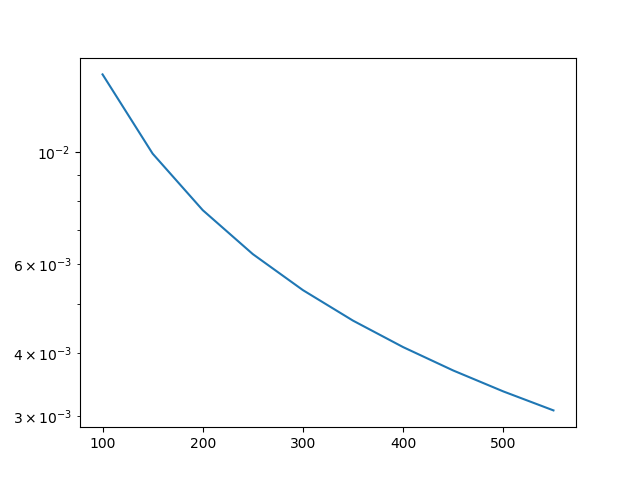

[0.01424202 0.00992039 0.00766595 0.0062725  0.00532205 0.00463052
 0.00410372 0.00368853 0.00335251 0.0030747 ]


In [342]:
plt.semilogy(N, E)
print(E)

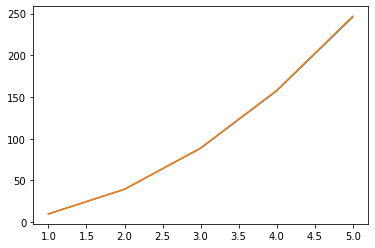

In [469]:
n = np.linspace(1, 5, 5)
plt.plot(n, np.absolute(vals))
plt.plot(n, (np.pi*n)**2)

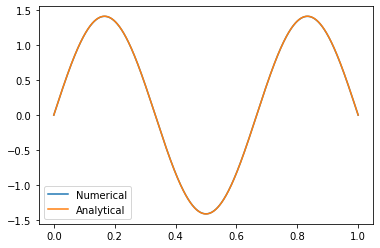

In [467]:
n = 2
x = np.linspace(0, 1, 1002)
plt.plot(x, np.real(modes[n]), label = "Numerical")
plt.plot(x, np.sqrt(2)*np.sin((n+1)*np.pi*x), label = "Analytical")
plt.legend()
#print(np.shape(functions))